# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of horses and zebras and teach a model to learn the visual transformation between the 2 animals.

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 


---

## Load and Visualize the Data

In [3]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `A` or `B`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data (= 1, as in the original CycleGAN paper)

This function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

In [28]:
def get_data_loader(image_type, image_size, batch_size, image_dir, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    image_path = image_dir
    # Uncomment if summer2winter:
    #train_path = os.path.join(image_path, image_type)  
    #test_path = os.path.join(image_path, 'test_{}'.format(image_type))
    train_path = os.path.join(image_path, 'train{}'.format(image_type))
    test_path = os.path.join(image_path, 'test{}'.format(image_type))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
image_dir_1 = 'summer2winter_yosemite'
image_dir_2 = 'apple2orange'
image_dir_3 = 'horse2zebra'

img_dir = image_dir_3
img_size = 128
batch_size = 1
dataloader_X, test_dataloader_X = get_data_loader(image_type='A', image_size = img_size, 
                                                  batch_size = batch_size, image_dir = img_dir)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='B', image_size = img_size, 
                                                  batch_size = batch_size, image_dir = img_dir)

print('# of horse images: ', len(dataloader_X))
print('# of zebra images: ', len(dataloader_Y))

# of horse images:  1067
# of zebra images:  1334


## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. 

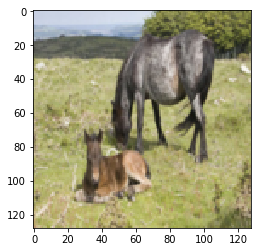

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(dataloader_X)
images, _ = dataiter.next()     # the "_" is a placeholder for no labels

fig = plt.figure()
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

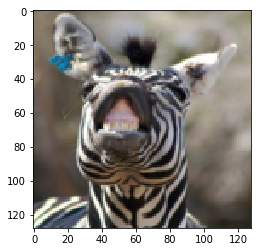

In [6]:
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

fig = plt.figure()
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
img = images[0]

print('Min: ', img.data.min())
print('Max: ', img.data.max())

Min:  tensor(0.0039)
Max:  tensor(1.)


In [8]:
def scale(x, feature_range=(-1, 1)):     # scale from 0-1 to feature_range
    ''' Scale takes in an image x and returns that image, scaled w/ feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255 .'''

    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [9]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9922)
Scaled max:  tensor(1.)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization."""
    
    layers = []
    layers.append( nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                             kernel_size=kernel_size, stride=stride, padding=padding, bias=False) )
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

* `__init__` function : specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. It's recommended to use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. 
* `forward` function : defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.


In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, kernel_size = 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size = 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size = 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size = 4)
        self.conv5 = conv(conv_dim*8, 1, kernel_size = 4, stride = 1, batch_norm=False)

    def forward(self, x):
        ########################################  Input x :      (3, 128, 128)
        x = F.leaky_relu(self.conv1(x), negative_slope = 0.2)  # (64, 64, 64)
        x = F.leaky_relu(self.conv2(x), negative_slope = 0.2)  # (128, 32, 32)
        x = F.leaky_relu(self.conv3(x), negative_slope = 0.2)  # (256, 16, 16)
        x = F.leaky_relu(self.conv4(x), negative_slope = 0.2)  # (512, 8, 8)
        x = self.conv5(x)                                      # (5, 5, 1)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. 

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [12]:
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.refl_padding = nn.ReflectionPad2d(1)
        self.conv1 = conv(conv_dim, conv_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = conv(conv_dim, conv_dim, kernel_size=3, stride=1, padding=0)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = self.refl_padding(x)   # (256, 34, 34)
        out = F.relu(self.conv1(out))  # (256, 32, 32)
        out = self.refl_padding(out)   # (256, 34, 34)
        out = self.conv2(out)          # (256, 32, 32)
        x = x + out
        
        return x    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [15]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* `__init__` function : specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* `forward` function : forward behavior of the generators with the last layer has a `tanh` activation function.
* **skip connection** for the last tanh layer helps the model to converge faster.


Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [16]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()
        # 1. Define the encoder part of the generator
        self.refl_padding = nn.ReflectionPad2d(3)
        
        self.conv1 = conv(3, conv_dim, kernel_size=7, stride=1, padding=0)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size = 3)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size = 3) 

        # 2. Define the resnet part of the generator
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_layers) 

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, kernel_size = 3)   
        self.deconv2 = deconv(conv_dim*2, conv_dim, kernel_size = 3)   
        # no batch norm on last layer
        self.conv_final = conv(conv_dim, 3, kernel_size=7, stride=1, padding=0, batch_norm=False)   # (3, 128, 128)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        ##############  Input x :      (3, 128, 128)
        out = self.refl_padding(x)     # (3, 134, 134)
        
        out = F.relu(self.conv1(out))    # (64, 128, 128)
        out = F.relu(self.conv2(out))    # (128, 64, 64)
        out = F.relu(self.conv3(out))    # (256, 32, 32)

        out = self.res_blocks(out)       # (256, 32, 32)

        out = F.relu(self.deconv1(out))  # (128, 64, 64)
        out = F.relu(self.deconv2(out))  # (64, 128, 128)
        
        out = self.refl_padding(out)     # (64, 134, 134)
        # skip layer
        out = F.tanh(x + self.conv_final(out))
        #out = F.tanh(self.conv_final(out))  # (3, 128, 128)

        return out

---
## Initialize Weights

As shown in the CycleGAN paper, we must initialize weights in the following way:

* Convolutional & Linear Layers: mean = 0.0, std = 0.02
* Batch Normalization Layers: mean = 1.0, std = 0.02
* Bias (if any) = 0.0

In [17]:
from torch.nn import init

def init_weights(m):
    
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
        
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [19]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_XtoY.apply(init_weights)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX.apply(init_weights)
    
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_X.apply(init_weights)
    D_Y = Discriminator(conv_dim=d_conv_dim)
    D_Y.apply(init_weights)
    

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [20]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Only CPU available.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [21]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (refl_padding): ReflectionPad2d((3, 3, 3, 3))
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (refl_padding): ReflectionPad2d((1, 1, 1, 1))
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1

)

                      D_X                      
-----------------------------------------------
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

                      D_Y              

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [22]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)


def fake_mse_loss(D_out):
    return torch.mean(D_out**2)


def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss as absolute value difference between the real and reconstructed images
    #try:
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
        
    #except RuntimeError:
        #min_batch = min(real_im.size(0), reconstructed_im.size(0))
        #reconstr_loss = torch.mean(torch.abs(real_im[:min_batch, :, :] - reconstructed_im[:min_batch, :, :]))
        #print('color_loss adjusted!')
        
    return lambda_weight * reconstr_loss  

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. We use the same learning rate for the first 100 epochs, then linearly decay it to 0 for epochs 100-200, as shown in the [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [23]:
import torch.optim as optim
beta1=0.5
beta2=0.999

def lr_decay(params, epoch):
    if epoch <= 100:
         lr = 0.0002
    else:
         lr = -(epoch-100)*0.0002/100 + 0.0002
    
    return optim.Adam(params, lr, [beta1, beta2])

## Discriminator: 50 Previous Generated Images Buffer

In the original paper, Discriminator is trained using a history of generated images with a buffer size of 50. Specifically,  when calculating Discriminator's fake_mse_loss, we choose a random generated image from 50 previously generated images, instead of using the current generated one. This helps introduce some randomness in trainingn the Discriminator.

In [25]:
# History of 50 images to use when updating the discriminator (pool_size = 50)
import random

def pick_from_pool(pool_size, fakes):
    
    fakes = [each.data for each in fakes]
    if len(fakes) <= pool_size:
        random_index = random.randint(0, len(fakes)-1)
        return fakes[random_index]
    
    else:
        fakes_50 = fakes[-50:]
        random_index = random.choice(np.arange(50))
        return fakes_50[random_index]

Below is a helper code to convert the image tensor into a numpy array, such that we can visualize or save the image.

In [26]:
def to_numpy(img):
    if torch.cuda.is_available:
        img = img.cpu()
    img = img.data.numpy()
    img = (((img+1)*255)/2).astype(np.uint8)
    img = img.squeeze(0).transpose(1, 2, 0)
    
    return img

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

In [21]:
import tqdm
################################ TRAIN THE MODEL ##############################
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs):
    
    print_every=1
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    #batches_per_epoch = min(len(iter_X), len(iter_Y))
    smaller = min(len(dataloader_X), len(dataloader_Y))
    batches_per_epoch = int(np.floor(smaller / batch_size)) # how many batches are in an epoch
    print('Batches per epoch: ', batches_per_epoch)
    
    for epoch in range(1, n_epochs+1):
        
        g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters
        g_optimizer = lr_decay(g_params, epoch)
        d_x_optimizer = lr_decay(D_X.parameters(), epoch)
        d_y_optimizer = lr_decay(D_Y.parameters(), epoch)
        
        fakes_X, fakes_Y = [], []
        #for i in tqdm.tqdm(range(batches_per_epoch)):
        for i in tqdm.tqdm(range(900)):

            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)
            
            images_X, _ = iter_X.next()
            images_X = scale(images_X) # make sure to scale to a range -1 to 1

            images_Y, _ = iter_Y.next()
            images_Y = scale(images_Y)
            
            '''
            XX = to_numpy(images_X)
            YY = to_numpy(images_Y)
            plt.imshow(XX)
            plt.show()
            plt.imshow(YY)
            plt.show()
            '''
            
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images_X = images_X.to(device)
            images_Y = images_Y.to(device)


            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================
            ##   1. D_X   ##
            d_x_optimizer.zero_grad()
            D_X_real_loss = real_mse_loss(D_X(images_X))

            fake_X = G_YtoX(images_Y)
            ###
            if i < 50:
                fakes_X.append(fake_X)
                fake_random = pick_from_pool(50, fakes_X)
            else:
                fakes_X.pop(0)
                fakes_X.append(fake_X)
                fake_random = pick_from_pool(50, fakes_X)
            ###
            D_X_fake_loss = fake_mse_loss(D_X(fake_random))

            d_x_loss = (D_X_real_loss + D_X_fake_loss) * 0.5
            d_x_loss.backward()
            d_x_optimizer.step()


            ##   2. D_Y   ##
            d_y_optimizer.zero_grad()
            D_Y_real_loss = real_mse_loss(D_Y(images_Y))

            fake_Y = G_XtoY(images_X)
            ###
            if i < 50:
                fakes_Y.append(fake_Y)
                fake_random = pick_from_pool(50, fakes_Y)
            else:
                fakes_Y.pop(0)
                fakes_Y.append(fake_Y)
                fake_random = pick_from_pool(50, fakes_Y)
            ###
            D_Y_fake_loss = fake_mse_loss(D_Y(fake_Y))

            d_y_loss = (D_Y_real_loss + D_Y_fake_loss) * 0.5
            d_y_loss.backward()
            d_y_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================
            g_optimizer.zero_grad()
            # 1. YtoX
            fake_X = G_YtoX(images_Y)
            g_YtoX_loss = real_mse_loss(D_X(fake_X))

            reconstructed_Y = G_XtoY(fake_X)
            reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

            # 2. XtoY
            fake_Y = G_XtoY(images_X)
            g_XtoY_loss = real_mse_loss(D_Y(fake_Y))

            reconstructed_X = G_YtoX(fake_Y)
            reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

            # 3. Add up all G losses
            g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
            g_total_loss.backward()
            g_optimizer.step()

        torch.save(D_X.state_dict(), 'D_X.pt')
        torch.save(D_Y.state_dict(), 'D_Y.pt')
        torch.save(G_XtoY.state_dict(), 'G_XtoY.pt')
        torch.save(G_YtoX.state_dict(), 'G_YtoX.pt')
        
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))


        sample_every=5
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            
            fake_sample_Y = G_XtoY(fixed_X.cuda())
            recon_sample_X = G_YtoX(fake_sample_Y)
            
            fake_sample_X = G_YtoX(fixed_Y.cuda())
            recon_sample_Y = G_XtoY(fake_sample_X)
            
            X, fake_X, recon_Y = to_numpy(fixed_X), to_numpy(fake_sample_X), to_numpy(recon_sample_Y)
            Y, fake_Y, recon_X = to_numpy(fixed_Y), to_numpy(fake_sample_Y), to_numpy(recon_sample_X)
            
            if(epoch == sample_every):
                plt.imsave('Input_X.png', X)
                plt.imsave('Input_Y.png', Y)
            
            plt.imsave('fake_sample_Y_'+str(epoch)+'.png', fake_Y)
            plt.imsave('recon_sample_X_'+str(epoch)+'.png', recon_X)
            
            plt.imsave('fake_sample_X_'+str(epoch)+'.png', fake_X)
            plt.imsave('recon_sample_Y_'+str(epoch)+'.png', recon_Y)
            print('Saved samples.')
            
            G_YtoX.train()
            G_XtoY.train()

    return losses

The training below for 55 epochs was performed in AWS Remote Computing. The original paper used 200 epochs, but we are using **Skip Connection** that incorporates the input at the last layer of Generator, which is assumed to help the model to converge faster. Training 55 epochs using AWS EC2 instance took around 6 hours.

In [27]:
n_epochs = 55 # same number of epochs used in the original cycleGAN paper

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

---
## Evaluate the Result!

Below are some examples of the generated images at Epoch = 25 and 55.

### 1. Horse -> Zebra

<img src='skip_A2B.png' width=50% height=50%>

From the result images above, it seems like with more iterations, Generator learned the zebra pattern more accurately in terms of fitting the shape of the horse. On the other hand, from Epoch 25 to 55, fading of colour in the zebra pattern can be observed from clean white to more brownish shades. 

### 2. Zebra -> Horse

<img src='skip_B2A.png' width=50% height=50% />

From the result images above, it seems like with more iterations, Generator learned to fade the black stripes of the zebras better. However, from epoch 25 to 55, the brown horse-ish color coating on the zebras also faded. This is a similar result with the Horse -> Zebra Generator in that both generators learn to fade out the colors (& saturation) with more iterations. 

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.


---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.